In [1]:
using Revise
using LinearAlgebra
using Statistics

import JLD
import PyPlot; plt = PyPlot
import CMF; cmf = CMF

include("./sep_plot_settings.jl")

┌ Info: Recompiling stale cache file /home/anthony/.julia/compiled/v1.1/CMF/0J4Dr.ji for CMF [db662885-8e4b-5931-925d-197754c06cb4]
└ @ Base loading.jl:1184
┌ Warning: Package CMF does not have ImageFiltering in its dependencies:
│ - If you have CMF checked out for development and have
│   added ImageFiltering as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with CMF
└ Loading ImageFiltering into CMF from project dependency, future warnings for CMF are suppressed.


set_size

## Load data

- Songbird data from: https://cdn.elifesciences.org/articles/38471/elife-38471-v1.pdf

In [2]:
scipy_io = PyCall.pyimport("scipy.io")
matfile = scipy_io.loadmat("../../cmf_data/MackeviciusData.mat")

song = matfile["SONG"];

## Fit data

In [3]:
K = 3
L = 20
n_trials = 30

algorithms = Dict(
    "Mult" => Dict(
        :alg => :mult, :max_itr => 60
    ),
    "ANLS" => Dict(
        :alg => :anls, :max_itr => 25
    ),
    "ANLS-1" => Dict(
        :alg => :anls, :max_itr => 1
    ),
    "HALS" => Dict(
        :alg => :hals, :max_itr => 20
    )
)
seed = sum([Int(c) for c in "SEPARABLITY"])
sep_thresh=10;

In [10]:
rs = cmf.fit_cnmf(
    song, K=K, L=L,
    alg=:sep, thresh=sep_thresh
)
println("Error: ", rs.loss_hist[end])

Error: 0.7318612410208795


In [11]:
rsep = Dict()

for alg in keys(algorithms)
    W, H = rs.W, rs.H
    if alg == "Mult"
        W = W .+ sqrt(eps())
        H = H .+ sqrt(eps())
    end
    
    rsep[alg] = cmf.fit_cnmf(
        song; K=K, L=L, max_time=Inf,
        initW=W, initH=H, 
        algorithms[alg]...
    )
    println(alg, " error: ", rsep[alg].loss_hist[end])
end

ANLS error: 0.5652845109187705
HALS error: 0.5706778502940185
Mult error: 0.5866765318608578
ANLS-1 error: 0.6552915134505218


In [9]:
rrand = Dict()

for alg in keys(algorithms)
    for tr in 1:n_trials
        rrand[string(tr, alg)] = cmf.fit_cnmf(
            song; K=K, L=L, max_time=Inf,
            seed=seed*tr,
            algorithms[alg]...
        )
    end
    println(alg, " finished.")
end

ANLS finished.
HALS finished.
Mult finished.
ANLS-1 finished.


In [87]:
JLD.save("./sep_songbird.jld", "rs", rs, "rsep", rsep, "rrand", rrand)

## Plot results

In [4]:
jd = JLD.load("./sep_songbird.jld")
rs = jd["rs"]
rsep = jd["rsep"]
rrand = jd["rrand"];

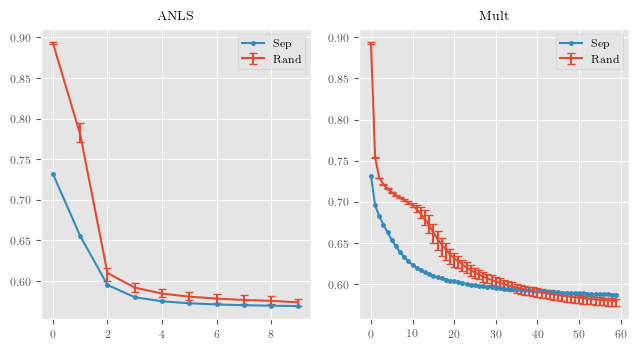

In [18]:
fig, axes = plt.subplots(1, 2, figsize=set_size(doc_textwidth, aspect=0.55))
displayitr = Dict("ANLS" => 10, "Mult" => 60)

for (i, alg) in enumerate(["ANLS", "Mult"])
    nitr = displayitr[alg]
    
    rand_losses = zeros(n_trials, nitr)
    for tr in 1:n_trials
        rand_losses[tr, :] = rrand[string(tr, alg)].loss_hist[1:nitr]
    end
    mean_rand = mean(rand_losses, dims=1)[1, :]
    error = std(rand_losses, dims=1)[1, :] * 3
    
    med_rand = median(rand_losses, dims=1)[1, :]
    iqr = hcat([quantile(rand_losses[:, j], [0.1, 0.9]) for j in 1:nitr]...)
    iqr = iqr - [med_rand'; med_rand']
    iqr[2, :] = -iqr[2, :]
    iqr = iqr
    
    axes[i].errorbar(0:nitr-1, med_rand, yerr=iqr,
                     label="Rand", markersize=0, capsize=3)
    axes[i].plot(0:nitr-1, rsep[alg].loss_hist[1:nitr],
                 label="Sep", markersize=5, marker=".")
    axes[i].set_title(alg)
    axes[i].legend()
end

plt.tight_layout(true)
plt.savefig("sepsong_loss.pdf")
plt.show()

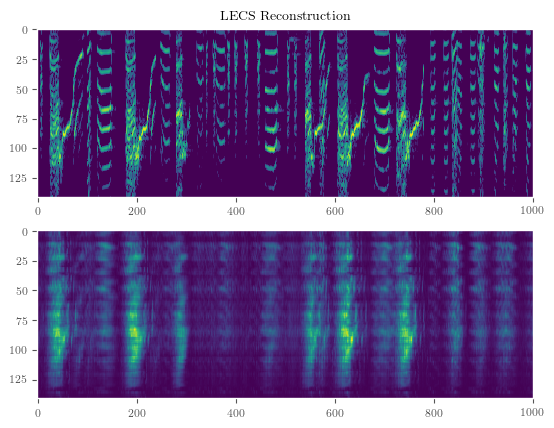

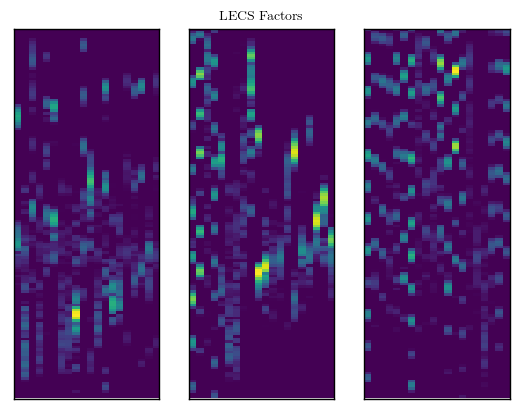

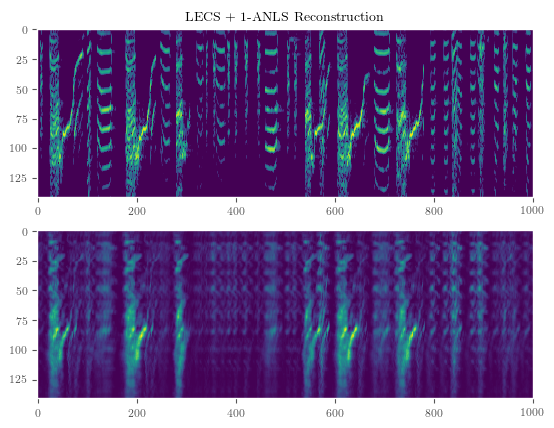

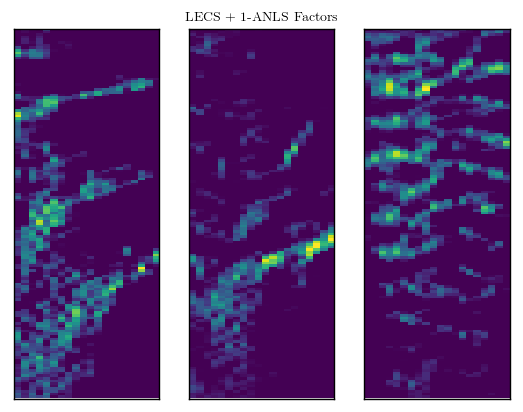

In [25]:
# Plot visual

fig1, axes1 = cmf.plot_reconstruction(rs, 1000:2000, sort_units=false)
axes1[1].set_title("LECS Reconstruction")
plt.savefig("song-lecs-rc.pdf")

fig2, axes2 = cmf.plot_Ws(rs, sort_units=false)
axes2[2].set_title("LECS Factors")
plt.savefig("song-lecs-fac.pdf")

fig3, axes3 = cmf.plot_reconstruction(rsep["ANLS-1"], 1000:2000, sort_units=false)
axes3[1].set_title("LECS + 1-ANLS Reconstruction")
plt.savefig("song-a1-rc.pdf")

fig4, axes4 = cmf.plot_Ws(rsep["ANLS-1"], sort_units=false)
axes4[2].set_title("LECS + 1-ANLS Factors")
plt.savefig("song-a1-fac.pdf")

## Supplement 1: Choosing $t$

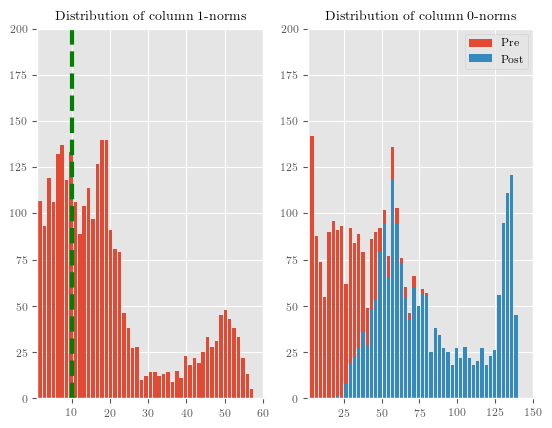

In [5]:
# Choice of threshold

function thresh(data, t)
    out = zeros(size(data))
    for j in 1:size(data, 2)
        if (sum(data[:, j]) > t)
            out[:, j] = data[:, j]
        end
    end
    return out
end

t = 10
songt = thresh(song, t)

powers1 = sum(song, dims=1)[1, :]
powers0_pre = sum(song .!= 0, dims=1)[1, :]
powers0_post = sum(songt .!= 0, dims=1)[1, :]

# Plot
plt.figure()

plt.subplot(1, 2, 1)
plt.hist(powers1, bins=50, rwidth=0.8)
plt.xlim([1, 60])
plt.ylim([0, 200])
plt.axvline(t, color="green", lw=3, ls="--")
plt.title("Distribution of column 1-norms")

plt.subplot(1, 2, 2)
plt.hist(powers0_pre, bins=50, rwidth=0.75, align="mid", label="Pre")
plt.hist(powers0_post, bins=50, rwidth=0.75, align="mid", label="Post")
plt.xlim([1.5, 150])
plt.ylim([0, 200])
plt.title("Distribution of column 0-norms")
plt.legend()

plt.show()

In [6]:
trange = range(0, stop=50, length=11)
rt = Dict()

for t in trange
    rt[t] = cmf.fit_cnmf(
        song, K=K, L=L,
        alg=:sep, thresh=t
    )
    println("Loss for t=", t, ":  ", rt[t].loss_hist[end])
end

Loss for t=5.0:  0.7286610948958069
Loss for t=10.0:  0.7318612410208795
Loss for t=15.0:  0.7337695347153501
Loss for t=20.0:  0.7315696940840348
Loss for t=25.0:  0.7339697713221605
Loss for t=30.0:  0.7304100193214049
Loss for t=35.0:  0.7320536669443249
Loss for t=40.0:  0.7342285315959921
Loss for t=45.0:  0.7797422524493896
Loss for t=50.0:  0.7434904609877747


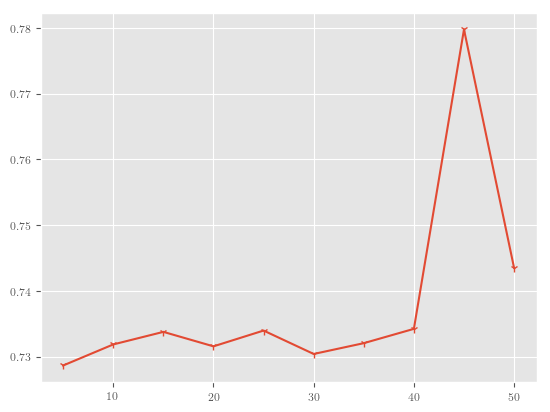

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f060f159550>

In [7]:
plt.plot(trange, [rt[t].loss_hist[end] for t in trange])    